In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video
import tempfile
import os
import shutil
import glob
import tqdm
import pandas as pd
import pyart
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif
from scipy.ndimage import gaussian_filter
from skimage.measure import regionprops
from load_radar import load_radar
import datetime as dt
from pymeso import llsd
import zipfile
import matplotlib.pyplot as plt
import tobac
def dealiase(radar, vel_name):
    #check to see if radar object has nyquist velocity
    try: 
        gatefilter = pyart.correct.GateFilter(radar)
        corr_vel   = pyart.correct.dealias_region_based(
            radar, vel_field=vel_name, keep_original=False, gatefilter = gatefilter)
        radar.add_field(vel_name, corr_vel, True)
    except:
        None
        
%matplotlib inline



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [5]:
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/admin/level_1b_v2/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: "+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[9].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)
                        
rid = "2"; #times = [dt.datetime(2020,1,31,3), dt.datetime(2020,1,31,9)]
times=[dt.datetime(2020,1,23,3,0), dt.datetime(2020,1,23,4,0)]

#Re-load gridded radar files, as well as raw radar files, in a format ready to send to TINT
unpack_level1b(rid, times)
grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                "%Y%m%d%H%M%S") for f in grid_files])
target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]
grids = (pyart.io.read_grid(fn) for fn in target_files)
radars = (None for fn in grid_files)

#Initialise TINT tracks and set tracking parameters
tracks_obj = Cell_tracks("corrected_reflectivity")
tracks_obj.params["FIELD_THRESH"]=30
tracks_obj.params["MIN_SIZE"]=200
tracks_obj.params["MIN_VOL"]=30
tracks_obj.params["MIN_HGT"]=2
tracks_obj.params["MAX_DISPARITY"]=60
tracks_obj.params["SEARCH_MARGIN"]=10000
tracks_obj.params["SKIMAGE_PROPS"]=["eccentricity","major_axis_length","minor_axis_length","bbox"]
tracks_obj.params["FIELD_DEPTH"]=5
tracks_obj.params["LOCAL_MAX_DIST"]=4
tracks_obj.params["AZI_SHEAR"]=True
tracks_obj.params["STEINER"]=True
tracks_obj.params["AZH1"]=2
tracks_obj.params["AZH2"]=6



In [7]:
target_files

array(['/scratch/eg3/ab4502/tint/2_20200123_030031_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_030628_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_031228_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_031828_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_032428_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_033031_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_033628_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_034228_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_034828_grid.nc',
       '/scratch/eg3/ab4502/tint/2_20200123_035428_grid.nc'], dtype='<U50')

In [6]:
from tint.tracks import *
from tint.objects import *

self = tracks_obj
    
FirstLoop = True
if self.record is None:
    # tracks object being initialized
    grid_obj2 = next(grids)
    self.grid_size = get_grid_size(grid_obj2)
    self.counter = Counter()
    self.record = Record(grid_obj2)
else:
    # tracks object being updated
    grid_obj2 = self.last_grid
    self.tracks.drop(self.record.scan + 1)  # last scan is overwritten

if self.current_objects is None:
    newRain = True
else:
    newRain = False

In [7]:
# from tint.grid_utils import *

# def clear_small_echoes(label_image, grid, min_size, min_vol, min_height, thresh):
#     """ Takes in binary image and clears objects less than min_size, min_height and min_vol. """
#     flat_image = pd.Series(label_image.flatten())
#     flat_image = flat_image[flat_image > 0]
#     size_table = flat_image.value_counts(sort=False)
#     small_objects = size_table.keys()[size_table < min_size]
            
#     for obj in small_objects:
#         label_image[label_image == obj] = 0

#     for obj in np.unique(label_image):
#         if obj > 0:                      
#             heights = (np.where(grid[:,label_image==obj] > thresh))[0]
#             if (((grid[:,label_image == obj] > thresh).sum()) < min_vol) | \
#                          ((heights.max() - heights.min()) < min_height):
#                 label_image[label_image == obj] = 0
    
#     #label_image = ndimage.label(label_image)
#     cnt=1
#     for obj in np.unique(label_image):
#         if obj > 0:
#             label_image[label_image==obj] = cnt
#             cnt=cnt+1
#     return label_image
    
# def get_filtered_frame(grid, min_size, min_vol, min_height, thresh):
#     """ Returns a labeled frame from gridded radar data. Smaller objects
#     are removed and the rest are labeled. """
#     echo_height = get_vert_projection(grid, thresh)
#     labeled_echo = ndimage.label(echo_height)[0]
#     frame = clear_small_echoes(labeled_echo, grid, min_size, min_vol, min_height, thresh)
#     return frame

# def extract_grid_data(grid_obj, field, grid_size, params):
#     """ Returns filtered grid frame and raw grid slice at global shift
#     altitude. """
#     min_size = params['MIN_SIZE'] / np.prod(grid_size[1:]/1000)
#     min_vol = params['MIN_VOL'] / np.prod(grid_size/1000)
#     min_height = params['MIN_HGT'] / np.prod(grid_size[0]/1000)
#     masked = grid_obj.fields[field]['data'] 
#     masked.data[masked.data == masked.fill_value] = 0
#     gs_alt = params['GS_ALT']
#     raw = masked.data[get_grid_alt(grid_size, gs_alt), :, :]
#     frame = get_filtered_frame(gaussian_filter(masked.data,0), min_size, min_vol, min_height,
#                                 params['FIELD_THRESH'])
#     return raw, frame

# raw2, frame2 = extract_grid_data(grid_obj2, self.field, self.grid_size,
#                                  self.params)
# plt.pcolormesh(frame2); plt.colorbar()

# colmax = grid_obj2.to_xarray().corrected_reflectivity.max("z").drop(["lat","lon"])
# colmax = colmax.where(~colmax.isnull(),0).to_iris()
# parameters_features={}
# parameters_features['position_threshold']='weighted_abs'
# parameters_features['sigma_threshold']=3
# #parameters_features['target']='maximum'
# parameters_features['threshold']=[30,35,50]
# #parameters_features['n_min_threshold']=0
# #parameters_features['min_distance']=0
# parameters_segmentation={}
# #parameters_segmentation['target']='maximum'
# #parameters_segmentation['method']='watershed'
# parameters_segmentation['threshold']=30
# Features=tobac.feature_detection.feature_detection_multithreshold(colmax,1000,**parameters_features)
# Mask_refl,Features_refl=tobac.segmentation.segmentation(Features,colmax,1000,**parameters_segmentation)

# plt.figure()
# plt.pcolormesh(Mask_refl.data); plt.colorbar()
# plt.figure()
# masked = grid_obj2.fields['corrected_reflectivity']['data'] 
# masked.data[masked.data == masked.fill_value] = 0
# params = self.params
# plt.pcolormesh(clear_small_echoes(Mask_refl.data, masked, params["MIN_SIZE"], params["MIN_VOL"], params["MIN_HGT"], params['FIELD_THRESH'])); plt.colorbar()


In [8]:
raw2, frame2 = extract_grid_data(grid_obj2, self.field, self.grid_size,
                                 self.params)

/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


array([143.01501448, 143.02661498, 143.03821553, 143.04981613,
       143.06141679, 143.07301751, 143.08461827, 143.09621909,
       143.10781996, 143.11942089, 143.13102187, 143.14262289,
       143.15422397, 143.1658251 , 143.17742629, 143.18902752,
       143.2006288 , 143.21223013, 143.22383151, 143.23543294,
       143.24703442, 143.25863594, 143.27023751, 143.28183913,
       143.2934408 , 143.30504251, 143.31664427, 143.32824608,
       143.33984793, 143.35144982, 143.36305176, 143.37465375,
       143.38625578, 143.39785785, 143.40945996, 143.42106212,
       143.43266432, 143.44426657, 143.45586885, 143.46747118,
       143.47907354, 143.49067595, 143.5022784 , 143.51388089,
       143.52548341, 143.53708598, 143.54868858, 143.56029123,
       143.57189391, 143.58349663, 143.59509938, 143.60670218,
       143.61830501, 143.62990787, 143.64151078, 143.65311371,
       143.66471669, 143.67631969, 143.68792273, 143.69952581,
       143.71112892, 143.72273206, 143.73433524, 143.74

In [17]:
while grid_obj2 is not None:
    grid_obj1 = grid_obj2
    raw1 = raw2
    frame1 = frame2

    try:
        grid_obj2 = next(grids)
    except StopIteration:
        grid_obj2 = None

    if grid_obj2 is not None:
        self.record.update_scan_and_time(grid_obj1, grid_obj2)
        raw2, frame2 = extract_grid_data(grid_obj2,
                                         self.field,
                                         self.grid_size,
                                         self.params)
    else:
        # setup to write final scan
        #self.__save()
        self.last_grid = grid_obj1
        self.record.update_scan_and_time(grid_obj1)
        raw2 = None
        frame2 = np.zeros_like(frame1)

    if np.max(frame1) == 0:
        newRain = True
        print('No cells found in scan', self.record.scan)
        self.current_objects = None
        self.tracks = write_null_tracks(self.tracks, self.record)
        continue

    global_shift = get_global_shift(raw1, raw2, self.params)
    pairs = get_pairs(frame1,
                      frame2,
                      global_shift,
                      self.current_objects,
                      self.record,
                      self.params)

    if newRain:
        # first nonempty scan after a period of empty scans
        self.current_objects, self.counter = init_current_objects(
            frame1,
            frame2,
            pairs,
            self.counter
        )
        newRain = False
    else:
        self.current_objects, self.counter = update_current_objects(
            frame1,
            frame2,
            pairs,
            self.current_objects,
            self.counter
        )

    obj_props = get_object_prop(frame1, grid_obj1, self.field, self.az_field,
                                self.record, self.params)
    self.record.add_uids(self.current_objects)
    self.tracks = write_tracks(self.tracks, self.record,
                              self.current_objects, obj_props, self.params, None)
#     if FirstLoop:
#         outgrids = Setup_h5File(grid_obj1, outdir)
#         FirstLoop = False
#    outgrids = write_griddata(outgrids,frame1,grid_obj1,self.field,self.current_objects,self.record,obj_props)
#    del grid_obj1, raw1, frame1, global_shift, pairs, obj_props   

/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


IndexError: index 0 is out of bounds for axis 0 with size 0

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [200]:
    if steiner:
        grid_dates = []; i=0
        while times[0] + dt.timedelta(days=1*i) <= times[1]:
            grid_dates.append((times[0] + dt.timedelta(days=1*i)).strftime("%Y%m%d"))
            i=i+1
        steiner_grid = xr.open_mfdataset(["/g/data/rq0/admin/level_2_v2/"+str(rid)+"/STEINER/"+str(rid)+"_"+d+"_steiner.nc" for d in grid_dates],\
                    decode_times=False).steiner
        steiner_grid = steiner_grid.assign_coords({"time":num2date(steiner_grid.time.values, steiner_grid.time.units, calendar=steiner_grid.time.calendar)}).load()
    else:   
        steiner_grid = False

In [201]:
steiner_grid

<xarray.DataArray 'steiner' (time: 240, y: 301, x: 301)>
dask.array<open_dataset-4ba2e2213bc557fea0ca372fb657cb5csteiner, shape=(240, 301, 301), dtype=float64, chunksize=(240, 301, 301), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int32 -150000 -149000 -148000 -147000 ... 148000 149000 150000
  * y        (y) int32 -150000 -149000 -148000 -147000 ... 148000 149000 150000
  * time     (time) object 2020-01-31 00:00:31 ... 2020-01-31 23:54:28
Attributes:
    units:        1
    long_name:    Steiner echo classification
    valid_min:    0
    valid_max:    2
    description:  Convective-stratiform echo classification based on Steiner ...
    comment:      0 = Undefined, 1 = Stratiform, 2 = Convective

In [222]:
obj=9
image1 = frame1
grid1 = grid_obj1
field = self.field
record = self.record
params = self.params
raw3D = grid1.fields[field]['data'].data
print(grid_obj1.time)
print(record.time)
print(grid_obj1)

{'long_name': 'Time of grid', 'units': 'seconds since 2020-01-31T08:54:28Z', 'standard_name': 'time', 'calendar': 'gregorian', 'data': masked_array(data=[0.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)}
2020-01-31 08:54:28


0.694


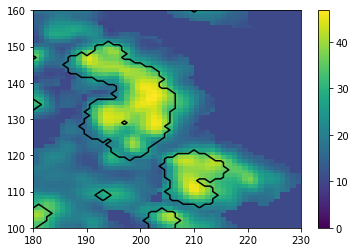

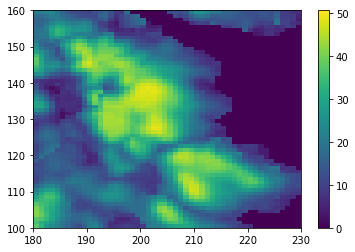

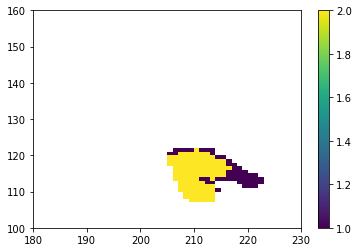

In [223]:
plt.pcolormesh(np.where(image1==obj, np.nanmax(raw3D,axis=0), 0)); 
plt.ylim([100,160]); plt.xlim([180,230])
plt.colorbar()

crop = np.where(image1==obj, np.nanmax(raw3D,axis=0), 0)

plt.pcolormesh(raw3D[5])
plt.contour(steiner.sel({"time":record.time}).steiner.values, colors="k", levels=[0.5,1.5,2.5])

plt.figure()
plt.pcolormesh(np.nanmax(raw3D,axis=0))
plt.colorbar()
plt.ylim([100,160]); plt.xlim([180,230])

plt.figure()
steiner_slice = np.where(image1==obj, steiner.sel({"time":record.time}).steiner.values, np.nan)
plt.pcolormesh(steiner_slice)
plt.ylim([100,160]); plt.xlim([180,230])
plt.colorbar()
if (steiner_slice>=1).sum() == 0:
        conv_pct = np.nan
else:
        conv_pct = (steiner_slice==2).sum() / (steiner_slice>=1).sum()
print(np.round(conv_pct,3))

In [236]:
obj_index = np.argwhere(image1 == obj)
obj_slices = [raw3D[:, ind[0], ind[1]] for ind in obj_index]


np.nanmin(np.where(image1 == obj, np.nanmax(raw3D,axis=0), np.nan))

30.0625

In [5]:
nobj = np.max(image1)

lons, lats = np.meshgrid(grid1.to_xarray()["lon"].values, grid1.to_xarray()["lat"].values)
interp = NearestNDInterpolator(np.stack([lons.flatten(), lats.flatten()]).T, image1.flatten())
# az_shear_meta = llsd.main(radar1,'reflectivity','velocity')
# radar1.add_field('azi_shear', az_shear_meta, replace_existing=True)
azi_shear36 = []
azi_shear02 = []
obj_36 = {k: [] for k in np.arange(nobj) + 1}
obj_02 = {k: [] for k in np.arange(nobj) + 1}
for s in np.arange(radar1.nsweeps):
    polar_x = radar1.get_gate_lat_lon_alt(s)[1][:, radar1.range["data"] < np.max(grid1.x["data"])]
    polar_y = radar1.get_gate_lat_lon_alt(s)[0][:, radar1.range["data"] < np.max(grid1.x["data"])]
    polar_z = radar1.get_gate_lat_lon_alt(s)[2][:, radar1.range["data"] < np.max(grid1.x["data"])]
    polar_obj = interp(polar_x, polar_y)
    for obj in np.arange(nobj) + 1:
        obj_36[obj].append(np.nanmax(np.abs(np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                        radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                        np.nan))))
    for obj in np.arange(nobj) + 1:
        obj_02[obj].append(np.nanmax(np.abs(np.where( (polar_obj==obj) & (polar_z >= 0) & (polar_z <= 2000),
                        radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                        np.nan))))
for obj in np.arange(nobj) + 1:
    azi_shear36.append(np.nanmax(obj_36[obj]))
    azi_shear02.append(np.nanmax(obj_02[obj]))
print(obj_36)
print(azi_shear36)


{1: [nan, 0.0, 1.359375, 0.9375, 0.2109375, 0.625, nan, nan, nan, nan, nan, nan, nan, nan], 2: [nan, nan, nan, nan, nan, 2.1875, 7.6015625, 13.1484375, 15.3125, 11.9375, nan, nan, nan, nan], 3: [nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 4: [nan, nan, 0.7421875, 2.9140625, 10.0234375, 10.9140625, 14.421875, 1.953125, nan, nan, nan, nan, nan, nan], 5: [nan, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 6: [nan, nan, 0.8515625, 0.5234375, 0.5078125, nan, nan, nan, nan, nan, nan, nan, nan, nan]}
[1.359375, 15.3125, 0.0, 14.421875, 0.0, 0.8515625]


15.3125


(-34.15, -33.9)

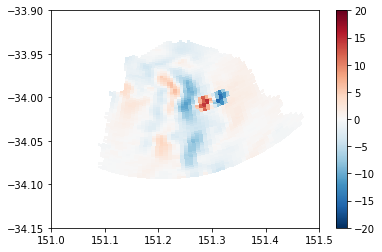

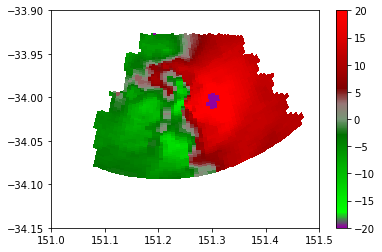

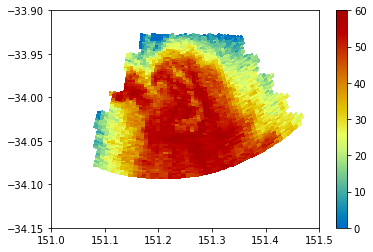

In [6]:
s = 8
obj = 2
polar_x = radar1.get_gate_lat_lon_alt(s)[1][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_y = radar1.get_gate_lat_lon_alt(s)[0][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_z = radar1.get_gate_lat_lon_alt(s)[2][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_obj = interp(polar_x, polar_y)
print(np.nanmax(np.abs(np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                np.nan))))

plt.pcolormesh(polar_x, polar_y, np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                radar1.get_field(s, "azi_shear")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                np.nan), vmin=-20, vmax=20, cmap=plt.cm.RdBu_r); plt.colorbar()
plt.xlim([151, 151.5]); plt.ylim([-34.15, -33.9])

plt.figure()
plt.pcolormesh(polar_x, polar_y, np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                radar1.get_field(s, "velocity")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                np.nan), vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel); plt.colorbar()
plt.xlim([151, 151.5]); plt.ylim([-34.15, -33.9])

plt.figure()
plt.pcolormesh(polar_x, polar_y, np.where( (polar_obj==obj) & (polar_z >= 3000) & (polar_z <= 6000),
                radar1.get_field(s, "reflectivity")[:, radar1.range["data"] < np.max(grid1.x["data"])],
                np.nan), vmin=0, vmax=60, cmap=pyart.graph.cm_colorblind.HomeyerRainbow); plt.colorbar()
plt.xlim([151, 151.5]); plt.ylim([-34.15, -33.9])

In [15]:
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/admin/level_1b_v2/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        file_dates = np.array([dt.datetime.strptime(f.split("/")[9][3:11], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0)) & (file_dates <= times[1].replace(hour=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)

datetime.datetime(2011, 12, 25, 0, 20)

In [26]:
s=8
obj=2
polar_x = radar1.get_gate_lat_lon_alt(s)[1][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_y = radar1.get_gate_lat_lon_alt(s)[0][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_z = radar1.get_gate_lat_lon_alt(s)[2][:, radar1.range["data"] < np.max(grid1.x["data"])]
polar_obj = interp(polar_x, polar_y)

In [153]:
from scipy.stats.mstats import gmean
df = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/50_20060101_20060131.csv")
df.columns

Index(['scan', 'uid', 'time', 'grid_x', 'grid_y', 'lon', 'lat', 'area_km',
       'vol', 'field_max', 'max_alt', 'isolated', 'local_max', 'azi_shear',
       'eccentricity', 'major_axis_length', 'minor_axis_length', 'bbox',
       'angle', 'speed', 'speed_inst'],
      dtype='object')

In [121]:
xr.open_dataset("/scratch/eg3/ab4502/tint/40_20201201_043031_grid.nc")

<xarray.Dataset>
Dimensions:                     (nradar: 1, time: 1, x: 301, y: 301, z: 41)
Coordinates:
  * time                        (time) datetime64[ns] 2020-12-01T04:30:31
  * x                           (x) float64 -1.5e+05 -1.49e+05 ... 1.5e+05
  * y                           (y) float64 -1.5e+05 -1.49e+05 ... 1.5e+05
  * z                           (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
Dimensions without coordinates: nradar
Data variables: (12/17)
    origin_latitude             (time) float64 ...
    origin_longitude            (time) float64 ...
    origin_altitude             (time) float64 ...
    projection                  int32 ...
    ProjectionCoordinateSystem  int32 ...
    radar_latitude              (nradar) float64 ...
    ...                          ...
    time_offset                 (time) datetime64[ns] ...
    corrected_reflectivity      (time, z, y, x) float32 ...
    corrected_velocity          (time, z, y, x) float32 ...
    azshear                     (time, z, y, x) float32 ...
    longitude                   (y, x) float32 ...
    latitude                    (y, x) float32 ...
Attributes: (12/51)
    summary:                   Level 1b dataset from the Australian radar net...
    history:                   created by Joshua Soderholm on gadi.nci.org.au...
    acknowledgement:           This work is support by the Bureau of Meteorol...
    institution:               Bureau of Meteorology
    keywords:                  radar, Doppler, dual-polarization
    licence:                   Freely Distributed
    ...                        ...
    grid_vert_range_m:         20000
    grid_horz_range_m:         150000.0
    grid_vert_shape:           41
    grid_horz_shape:           301
    grid_vert_resolution_m:    500.0
    grid_horz_resolution_m:    1000.0

nan